# Generate SMILES with the trained BART model
- explore the generating process, 
- find out why the huggingface's generate function acts weird
- look at BEAM SEARCH
- all the rest from NOTES

## Initialization

In [3]:
# imports
import os,sys,inspect, io
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)
import torch
import numpy as np
from transformers import BartForConditionalGeneration

# custom veci
from dataset import SpectroDataset, SpectroDataCollator
sys.path.append('data')
sys.path.append('bart_spektro')
from modeling_bart_spektro import BartSpektoForConditionalGeneration
from configuration_bart_spektro import BartSpektroConfig
from data_preprocess1 import print_args
from bart_spektro_tokenizer import BartSpektroTokenizer
from tokenizers import Tokenizer


In [4]:
# silent environment (no prints)
import contextlib
@contextlib.contextmanager
def silence():
    sys.stdout, old = io.StringIO(), sys.stdout
    try:
        yield
    finally:
        sys.stdout = old

In [6]:
# DATA loading
data_type = "8M"
tokenizer_type = "_bbpe_1M" # ""
# test_data_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_test.pkl'
# train_data_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_train.pkl'
test_data_path = f'./data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_test.pkl'
train_data_path = f'./data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_train.pkl'

test_data = SpectroDataset(test_data_path, original=False, gen_mode=False)
# train_data = SpectroDataset(train_data_path, original=False, gen_mode=False)

In [7]:
# MODEL loading
if tokenizer_type:
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-21-14_51_12_2xA100/checkpoint-3460'
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-01-09_52_21_bbpe1M_IDs/checkpoint-6920/'
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-22-20_54_40_4xA40_ga4/checkpoint-6920/'
    model_path = f'./models/bart_2022-06-28-10_02_31_bigdata/checkpoint-99704/'
else:
    model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-05-10-16_06_04_P_IDs/checkpoint-6920/'
    
    
model = BartSpektoForConditionalGeneration.from_pretrained(model_path)

# put model into eval mode and on device
model.eval()
device = 'cuda' # 'cpu' alternatively
model.to(device)

# TOKENIZER loading
if tokenizer_type:
    tok = "./tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
    tokenizer = Tokenizer.from_file(tok)
else:
    with silence():
        tokenizer = BartSpektroTokenizer().init_tokenizer()

In [8]:
# change configs
if tokenizer_type:
    model.config.eos_token_id = 0
    model.config.bos_token_id = 3
    model.config.pad_token_id = 2
    model.config.decoder_start_token_id = 3
    model.config.forced_eos_token_id = 0
else: 
    model.config.eos_token_id = 502
    model.config.bos_token_id = 503
    model.config.pad_token_id = 501
    model.config.decoder_start_token_id = 503
    model.config.forced_eos_token_id = 502
    
model.config.max_length = 200
model.config.min_length = 0
#########################

In [9]:
test_data.data.head(3)

,destereo_smiles,input_ids,decoder_input_ids,encoder_attention_mask,decoder_attention_mask,labels,position_ids
0,FC(c1ccc2n(c1)c(N)cn2)(F)F,"[14, 19, 25, 26, 27, 28, 31, 33, 36, 37, 38, 3...","[3, 224, 495, 11, 70, 20, 280, 21, 81, 11, 70,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 224, 495, 11, 70, 20, 280, 21, 81, 11, 70,...","[1, 1, 2, 4, 3, 5, 3, 1, 0, 5, 6, 7, 6, 7, 6, ..."
1,NC(=O)c1n[nH]c(c1)c1cccnc1,"[29, 30, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[3, 224, 265, 260, 50, 12, 70, 20, 81, 62, 277...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 224, 265, 260, 50, 12, 70, 20, 81, 62, 277...","[0, 5, 1, 5, 6, 7, 6, 6, 4, 2, 7, 0, 1, 7, 7, ..."
2,CCc1ccc2c(c1Br)ccnc2,"[26, 27, 36, 37, 38, 39, 40, 41, 42, 43, 44, 4...","[3, 224, 303, 20, 280, 21, 70, 11, 70, 20, 466...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[3, 224, 303, 20, 280, 21, 70, 11, 70, 20, 466...","[4, 4, 1, 6, 6, 7, 5, 6, 4, 6, 6, 2, 0, 6, 8, ..."


## Playing with generation
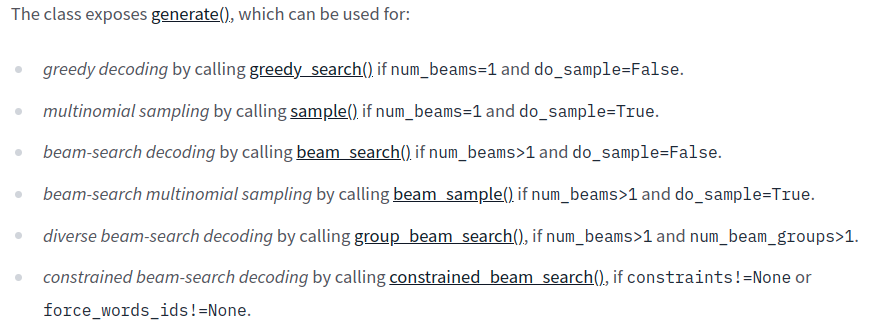

In [10]:
def generate_smiles(inputs, top_k=200, top_p=0.8, do_sample=True, num_beams=1, temperature=1, model=model):
    with torch.no_grad():
#         outputs = model(input_ids = inputs["input_ids"].unsqueeze(0).to(device=device), 
#                         position_ids = inputs["position_ids"].unsqueeze(0).to(device=device),
#                         labels = inputs["labels"].unsqueeze(0).to(device=device))
        generated = model.generate(
                       input_ids=inputs["input_ids"].unsqueeze(0).to(device=device), 
                       position_ids=inputs["position_ids"].unsqueeze(0).to(device=device),
                       top_p=top_p,
                       top_k=top_k,
    #                    min_length=20,
    #                    max_length=200,
                       do_sample=do_sample,
                       num_beams=num_beams,
                       temperature=temperature
                       ).tolist()[0]
        return inputs, generated

In [10]:
inputs, generated = generate_smiles(test_data[300])

                                                       
                            ############ PRINTING #############
# GROUND TRUTH
print("##### GROUND TRUTH #####")
x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
if tokenizer_type:
    gt_smiles = tokenizer.decode(x)
    print("ground truth SMILES:", gt_smiles, "\n")
else:
    print("ground truth SMILES:", tokenizer.ids_to_smiles(x[x>0]), "\n")
print("ground truth ids:", x[x>0], "\n")
# print("mask:", inputs["decoder_attention_mask"].tolist(), "\n\n")

# GENERATED
print("##### GENERATED #####")
if tokenizer_type:
    print("generated:", tokenizer.decode(generated), "\n")
else:
    print("generated SMILES:", tokenizer.ids_to_smiles(generated), "\n")
print("generated ids:", generated, "\n")

# LOSSES
# print("##### LOSSES #####")
# print(f"loss: {outputs.loss}")
# print(f"logit bos: {outputs.logits[0][68][503].cpu().numpy()}")

##### GROUND TRUTH #####
ground truth SMILES:  CC1(N)COC1 

ground truth ids: [  3 224 261  20  11  49  12 285  20] 

##### GENERATED #####
generated:  CCC(NN)(C)C 

generated ids: [3, 3, 224, 276, 11, 405, 289, 38, 12, 38, 0] 



In [8]:
sorted(tokenizer.get_vocab().items(), key=lambda x: x[1])

[('\x01', 500),
 ('\x02', 501),
 ('\x03', 502),
 ('\x04', 503),
 ('[', 504),
 (']', 505),
 ('(', 506),
 (')', 507),
 ('.', 508),
 ('-', 509),
 ('=', 510),
 ('#', 511),
 ('$', 512),
 (':', 513),
 ('/', 514),
 ('\\', 515),
 ('%', 516),
 ('@', 517),
 ('+', 518),
 ('0', 519),
 ('1', 520),
 ('2', 521),
 ('3', 522),
 ('4', 523),
 ('5', 524),
 ('6', 525),
 ('7', 526),
 ('8', 527),
 ('9', 528),
 ('A', 529),
 ('B', 530),
 ('C', 531),
 ('D', 532),
 ('E', 533),
 ('F', 534),
 ('G', 535),
 ('H', 536),
 ('I', 537),
 ('K', 538),
 ('L', 539),
 ('M', 540),
 ('N', 541),
 ('O', 542),
 ('P', 543),
 ('R', 544),
 ('S', 545),
 ('T', 546),
 ('U', 547),
 ('V', 548),
 ('W', 549),
 ('X', 550),
 ('Y', 551),
 ('Z', 552),
 ('a', 553),
 ('b', 554),
 ('c', 555),
 ('d', 556),
 ('e', 557),
 ('f', 558),
 ('g', 559),
 ('h', 560),
 ('i', 561),
 ('k', 562),
 ('l', 563),
 ('m', 564),
 ('n', 565),
 ('o', 566),
 ('p', 567),
 ('r', 568),
 ('s', 569),
 ('t', 570),
 ('u', 571),
 ('v', 572),
 ('w', 573),
 ('x', 574),
 ('y', 575),

## Inference / Evaluation
- COMMON PHASE
- generate 100 (?1000) SMILES
- remove redundancy
- filter the invalid ones <br>
=> Tanimoto wit the ground truth
    
    
## Extended inference
- OPTION 1
    - with NEIMS generate spektra
    - compare with original one (weighted CS)
    - sort according to the similarity
- OPTION 2 (~ VAE-search)
    - take the best predicted MOLECULE
    - encode it using VAE into a LATENT SPACE representation
    - do slight changes to this representation
    - generate SMILESs again
    - filter invalid ones (99.9%)          

### Common phase
- generate 100 (?1000) SMILES
- remove redundancy (not during evaluation)
- filter the invalid ones <br>
=> Tanimoto wit the ground truth
    


In [11]:
%%time
from pandas import Series, DataFrame
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from IPython.display import HTML

#topk=200
#topp=0.8
def evaluate_datapoint(inputs, num_generated=10, return_best=3, top_k=None, top_p=0.8, do_sample=True, num_beams=1, temperature=None, printing=True):
#     inputs = data[id_]
    if tokenizer_type:
        gt_smiles = tokenizer.decode(list(np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist()))[1:-1])
    else:
        x = np.array(inputs["labels"].tolist())*np.array(inputs["decoder_attention_mask"].tolist())
        gt_smiles = tokenizer.ids_to_smiles(x[x>0][1:-1])
    generated_smiless = []
    
    # generate
    for _ in range(num_generated):
        _, generated = generate_smiles(inputs, top_k=top_k, top_p=top_p, do_sample=do_sample, num_beams=num_beams, temperature=temperature)
        if tokenizer_type:
            generated_smiless.append(tokenizer.decode(generated[1:-1]))
        else:
            generated_smiless.append(tokenizer.ids_to_smiles(generated[1:-1]))
    
    # deduplicate
    unique_smiless = generated_smiless # np.unique(np.array(generated_smiless)) #####################################
    
    # filter invalid
    valid_smiless = [s for s in unique_smiless if Chem.MolFromSmiles(s)]
    
    # compute similarity
    ms = [Chem.MolFromSmiles(smiles) for smiles in valid_smiless]
    gt_fp = Chem.RDKFingerprint(Chem.MolFromSmiles(gt_smiles)) 
    fps = [Chem.RDKFingerprint(x) for x in ms if x]
    simils = [DataStructs.FingerprintSimilarity(fp, gt_fp) for fp in fps]
    smile_simil = list(zip(valid_smiless,simils))
    smile_simil.sort(key=lambda x: x[1], reverse=True)
    if printing == True:
        print("ground truth SMILES:", gt_smiles, "\n") ############################################
        print("num of uniques:", len(unique_smiless)) ##############################################
        print(smile_simil) #################################################################
        print("\n\nThe best:", smile_simil[0]) if smile_simil else print("\n\nNo suitable candidates :(") ###########################
    
#     df = DataFrame({"SMILES": valid_smiless, "molecule": ms, "similarity": simils}).sort_values(by="similarity", ascending=False)
#     return df
    result = sorted(simils, reverse=True)[:return_best]
    if len(result) < return_best:
        result = result + [0]*(return_best-len(result))
    return result

evaluate_datapoint(test_data[32]) #908

/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


ground truth SMILES:  CCN1CCC2C(C1)OCCN2 

num of uniques: 10
[(' CCN1CCC(CC1)NC(C)C', 0.33630952380952384), (' CCN1CCC(CC1)NCC(C)C', 0.32753623188405795), (' CCN1CCC(CC1)NCC(C)C', 0.32753623188405795), (' CCN1CCC(CC1)N1CCCO1', 0.29646017699115046), (' CCN1CCC(CC1)N1CCCO1', 0.29646017699115046), (' CCN1CCC(C1)N1CCOC1', 0.28274428274428276), (' CCN1CCC(C1)N1CCOC1', 0.28274428274428276), (' CCNC1CCN(C1)CCC', 0.22879177377892032), (' CCN1CCC(C1)N1CCCO1', 0.20107719928186715), (' CCN1CCC(C1)N1CCCO1', 0.20107719928186715)]


The best: (' CCN1CCC(CC1)NC(C)C', 0.33630952380952384)
CPU times: user 1.52 s, sys: 1.5 s, total: 3.02 s
Wall time: 4.62 s


[0.33630952380952384, 0.32753623188405795, 0.32753623188405795]

### Evaluation Loop
- take model, tokenizer, data, generation settings
- for the first 100 examples generate <num_generated> samples
- average the best three samples for each example -> average across all examples
- average the best samples across all examples

In [15]:
# initialization (copy paste from the beginning)

# DATA init
data_type = "1M"
tokenizer_type = "_bbpe_1M" # ""
test_data_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_test.pkl'
train_data_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/data/trial_set/{data_type}{tokenizer_type}_bart_prepared_data_train.pkl'
test_data = SpectroDataset(test_data_path, original=False, gen_mode=False)
train_data = SpectroDataset(train_data_path, original=False, gen_mode=False)

# MODEL loading
if tokenizer_type:
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-21-14_51_12_2xA100/checkpoint-3460/'
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-01-09_52_21_bbpe1M_IDs/checkpoint-6920/'
    model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-06-22-20_54_40_4xA40_ga4/checkpoint-6920/'
else:
#     model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-05-10-16_06_04_P_IDs/checkpoint-6920/'
    model_path = f'/storage/projects/msml/mg_neims_branch/MassGenie/models/bart_2022-05-11-14_44_04_NO_P_IDs/checkpoint-6920/'
    

model = BartSpektoForConditionalGeneration.from_pretrained(model_path)  ###########!!!!!#################
# model = BartForConditionalGeneration.from_pretrained(model_path) # only for NO_ID


# put model into eval mode and on device
model.eval()
device = 'cuda' # 'cpu' alternatively
model.to(device)

# TOKENIZER loading
if tokenizer_type:
    tok = "./tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
    tokenizer = Tokenizer.from_file(tok)
else:
    with silence():
        tokenizer = BartSpektroTokenizer().init_tokenizer()

# change configs
if tokenizer_type:
    model.config.eos_token_id = 0
    model.config.bos_token_id = 3
    model.config.pad_token_id = 2
    model.config.decoder_start_token_id = 3
    model.config.forced_eos_token_id = 0
else: 
    model.config.eos_token_id = 502
    model.config.bos_token_id = 503
    model.config.pad_token_id = 501
    model.config.decoder_start_token_id = 503
    model.config.forced_eos_token_id = 502
    
model.config.max_length = 200
model.config.min_length = 0

KeyboardInterrupt: 

  0%|          | 0/1000 [00:00<?, ?it/s]/storage/brno2/home/ahajek/.local-Pytorch-21.SIF/lib/python3.8/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 200 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
[21:16:13] Explicit valence for atom # 18 O, 4, is greater than permitted
  1%|          | 11/1000 [00:24<36:43,  2.23s/it][21:16:37] SMILES Parse Error: extra close parentheses while parsing: CC(=O)Nc1ccc2c(c1)C1CCCC(=O)C2)C1
[21:16:37] SMILES Parse Error: Failed parsing SMILES ' CC(=O)Nc1ccc2c(c1)C1CCCC(=O)C2)C1' for input: ' CC(=O)Nc1ccc2c(c1)C1CCCC(=O)C2)C1'
[21:16:37] SMILES Parse Error: unclosed ring for input: ' CC(=O)Nc1ccc2c(c1)C1CCCC(=O)C2'
[21:16:37] SMILES Parse Erro

###### RESULTS ######
model: bart_2022-06-28-10_02_31_bigdata
range: (15000, 15999)
generated for each example: 10 samples
data type: 8M
average from the 3 best samples: 0.7189948619017722
average from the 1 best sample: 0.7702949803317618

1st_bests: [0.6891271056661562, 0.16216216216216217, 1.0, 0.38847117794486213, 1.0, 0.5899632802937577, 1.0, 0.6425992779783394, 0.6117021276595744, 0.7711864406779662, 0.2772727272727273, 0.3120494335736354, 0.8528428093645485, 1.0, 0.7266666666666667, 1.0, 0.5164644714038128, 1.0, 0.24463007159904535, 0.44011976047904194, 0.6098901098901099, 1.0, 0.4244306418219462, 0.8140495867768595, 1.0, 0.9840686274509803, 0.43829516539440205, 1.0, 0.9659239842726082, 1.0, 0.4372623574144487, 0.62853470437018, 1.0, 1.0, 0.21228070175438596, 0.5144827586206897, 1.0, 1.0, 0.9052132701421801, 1.0, 0.5221354166666666, 1.0, 1.0, 0.23573573573573572, 0.4267399267399267, 1.0, 0.8, 1.0, 0.8126315789473684, 0.6733466933867736, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5122448979

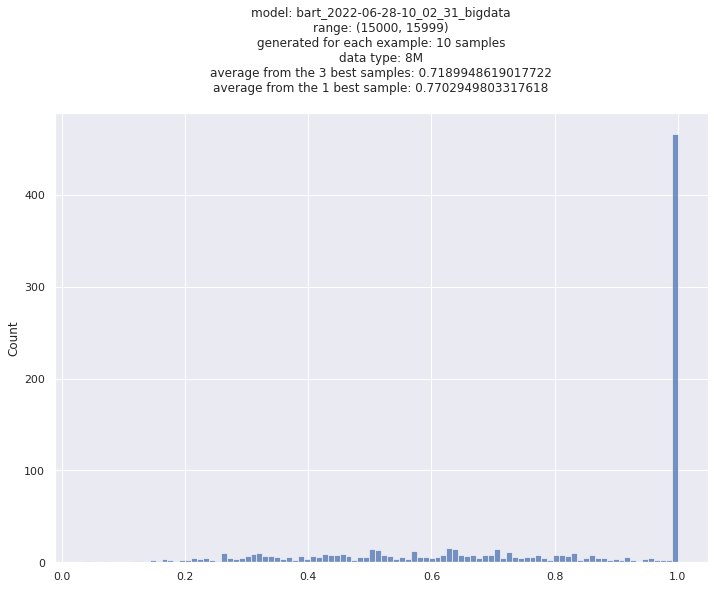

In [12]:
# %%time
from tqdm import tqdm
import seaborn as sns
def evaluate_model(data, data_range=range(100), num_generated=10, return_best=3, top_k=200, top_p=0.8, do_sample=True, num_beams=1, temperature=None):
    topNsum = 0
    top1sum = 0
    i = 0
    all_top1 = []
    for id_ in tqdm(data_range):
        simils = evaluate_datapoint(data[id_], num_generated=10, return_best=return_best, top_k=top_k, top_p=top_p, do_sample=do_sample, num_beams=num_beams, temperature=temperature, printing=False)
        topNsum += sum(simils)
        top1sum += simils[0]
        all_top1.append(simils[0])
    topNaverage = topNsum/(len(data_range)*return_best)
    top1average = top1sum/len(data_range)
    
    model_name = ''.join(model_path.split('/')[-3])
    output_text = \
          f"model: {model_name}\n" + \
          f"range: ({min(data_range)}, {max(data_range)})\n"+ \
          f"generated for each example: {num_generated} samples\n"+\
          f"data type: {data_type}\n" +\
          f"average from the {return_best} best samples: {topNaverage}\n"+\
          f"average from the 1 best sample: {top1average}\n"
    print( f"###### RESULTS ######\n" + output_text)
    print(f"1st_bests: {all_top1}")
    
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    histplot = sns.histplot(all_top1, bins=100)
    histplot.set_title(output_text)
    fig = histplot.get_figure()
    fig.savefig(f"figures/histo_{model_name}_{data_type}_({min(data_range)}, {max(data_range)}).png", bbox_inches='tight') 
    return histplot
    
hist = evaluate_model(test_data, data_range=range(15000,16000)) # bbpe
# evaluate_model(test_data, data_range=range(15000, 16000), top_k=None, top_p=0.8) # non bbpe

### Visualization of molecules

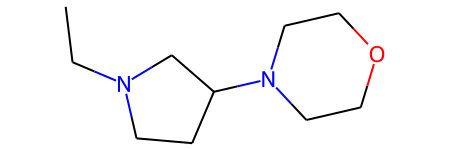

In [22]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

# Test in a kinase inhibitor
mol = Chem.MolFromSmiles("CCN1CCC(C1)N1CCOCC1")
# Default
mol

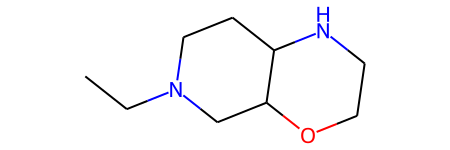

In [13]:
# Test in a kinase inhibitor
mol = Chem.MolFromSmiles("CCN1CCC2C(C1)OCCN2")
# Default
mol

<AxesSubplot:ylabel='Count'>

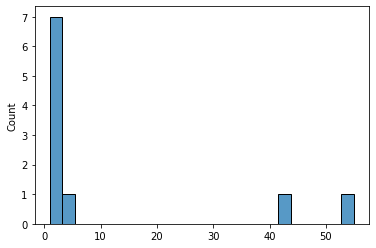

In [30]:
# test
import seaborn as sns

sns.histplot([1,2,3,4,55,43,2,2,1,1])